In [1]:
# ディープラーニングモデルの作成

import numpy as np

# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

import pandas as pd

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [2]:
# データのロード

import pandas_datareader.data as pdr
import datetime

start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2020, 12, 31)

# ウェルスナビで使用している6銘柄
pd_data = pdr.DataReader(['VTI','VEA','VWO','AGG','GLD','IYR'], 'yahoo', start, end)
data_close = pd_data['Close']
 
data_close.head() 

Symbols,VTI,VEA,VWO,AGG,GLD,IYR
Date,,,,,,
2019-12-31,163.619995,44.060001,44.470001,112.370003,142.899994,93.080002
2020-01-02,164.979996,44.419998,45.529999,112.680000,143.949997,92.050003
2020-01-03,163.929993,43.880001,44.720001,113.010002,145.860001,92.709999
2020-01-06,164.490005,44.029999,44.639999,112.919998,147.389999,92.790001
2020-01-07,164.100006,43.959999,44.619999,112.800003,147.970001,91.849998


In [3]:
# モデルを用いて資産配分を計算
model = Model()
alc = model.get_allocations(data_close)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0317
Epoch 2/20
1/1 [==============================] - 0s 113ms/step - loss: -0.0324
Epoch 3/20
1/1 [==============================] - 0s 104ms/step - loss: -0.0333
Epoch 4/20
1/1 [==============================] - 0s 105ms/step - loss: -0.0346
Epoch 5/20
1/1 [==============================] - 0s 104ms/step - loss: -0.0365
Epoch 6/20
1/1 [==============================] - 0s 92ms/step - loss: -0.0386
Epoch 7/20
1/1 [==============================] - 0s 96ms/step - loss: -0.0410
Epoch 8/20
1/1 [==============================] - 0s 123ms/step - loss: -0.0434
Epoch 9/20
1/1 [==============================] - 0s 99ms/step - loss: -0.0453
Epoch 10/20
1/1 [==============================] - 0s 111ms/step - loss: -0.0467
Epoch 11/20
1/1 [==============================] - 0s 102ms/step - loss: -0.0478
Epoch 12/20
1/1 [==============================] - 0s 97ms/step - loss: -0.0488
Epoch 13/20
1/1 [===========================

/home/nske/miniconda3/envs/jp/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  """


([<matplotlib.patches.Wedge at 0x7fcc44361b10>,
 [Text(0.8361403602202601, 0.7147512140673382, 'VTI'),
  Text(-0.23849021137016868, 1.07383537801686, 'VEA'),
  Text(-0.7429298364067388, 0.8112060516149128, 'VWO'),
  Text(-1.09952890531088, 0.03218984911207009, 'AGG'),
  Text(0.22578612371190762, -1.0765782026119382, 'GLD'),
  Text(1.0939920973737025, -0.1148098030826978, 'IYR')])

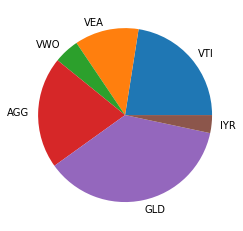

In [4]:
# 算出した比率をプロット

import matplotlib.pyplot as plt

plt.pie(alc, labels=data_close.columns.tolist())